# Rotary Positional Embeddings (RoPE)

To understand RoPE, you must fundamentally change how you view "position."

- **Old View (Absolute/Learnable):** Position is a signal we add to the data.
- **New View (RoPE):** Position is an orientation in space.

## Core Idea of RoPE (one sentence)

**RoPE rotates token embeddings in a position-dependent way so that attention naturally understands relative distance.**

## Why Rotation Works Better Than Addition

### Learnable Embeddings (old way)
```
embedding = word_vector + position_vector
```

**Problem:**
- Position info is mixed with meaning
- Hard to infer distance

### RoPE (new way)
```
embedding = ROTATE(word_vector, angle = position)
```

**Key advantage:**
- Rotation preserves length
- Only changes direction
- Relative angle difference = relative position difference

## How Rotation is Done (simple math, no fear)

Each embedding is split into pairs:
```
[x1, x2], [x3, x4], [x5, x6], ...
```

Each pair acts like a **2D vector**.

### Rotation Formula:
```
[x', y'] = [ x*cosθ - y*sinθ ,
             x*sinθ + y*cosθ ]
```

**θ (theta) depends on:**
- Token position
- Embedding dimension

## The Math: Rotation Matrices

Imagine a 2D vector $(x_1, x_2)$. In the complex plane, this is $x_1 + i x_2$.

To rotate this vector by an angle $\theta$, we multiply it by $e^{i\theta}$.

### How RoPE Works

RoPE applies this to the high-dimensional embedding vector by **chopping it into chunks of 2**.

If $d_{model} = 512$, we treat it as **256 pairs** of coordinates.

### The Rotation Formula

For a token at position $m$, we rotate the pair $(x_1, x_2)$ by an angle $m \theta$:

$$\begin{pmatrix} x'_1 \\ x'_2 \end{pmatrix} = \begin{pmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$$

### The Magic Property ✨

If you take the dot product of a **Query** rotated by $m\theta$ and a **Key** rotated by $n\theta$, the math simplifies beautifully:

$$\text{Score} = \text{OriginalScore} \times \cos((m - n)\theta)$$

**The absolute positions $m$ and $n$ disappear!** Only the relative distance $(m - n)$ remains.

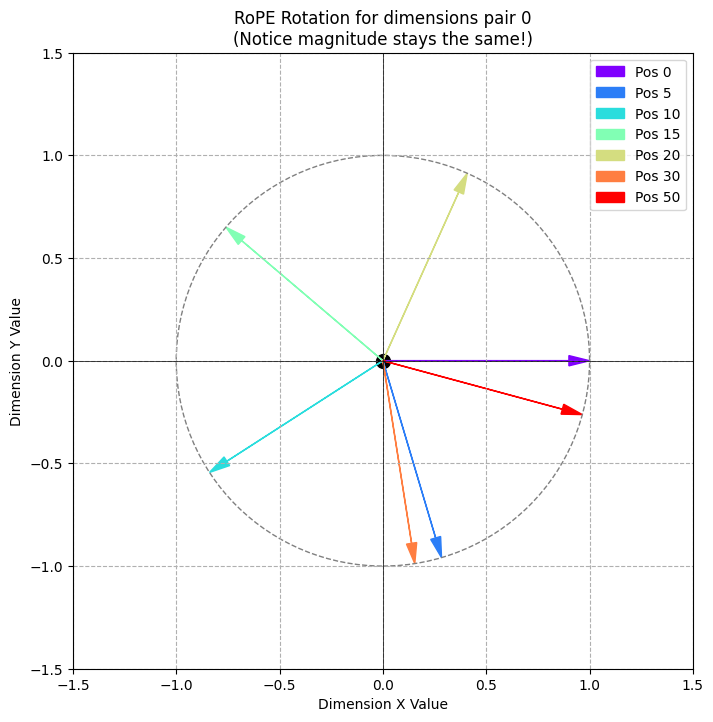

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Configuration ---
d_model = 64          # Total dimensions
head_dim_pair = 0     # We are looking at the very first pair of dimensions (the fastest rotation)
base_vector = np.array([1.0, 0.0]) # Our starting vector (pointing right along X-axis)
positions_to_plot = [0, 5, 10, 15, 20, 30, 50]

# --- Helper Function: Calculate RoPE Rotation for 2D ---
def get_rotated_2d_vector(vector, position, d_model, pair_index):
    """
    Calculates the rotation for a single pair of dimensions at a given position.
    """
    # 1. Calculate the frequency angle (theta) for this specific pair
    # Formula: theta_i = 10000^(-2i/d)
    theta = 1.0 / (10000 ** ((2 * pair_index) / d_model))
    
    # 2. Calculate total rotation angle for this position
    angle_rad = position * theta
    
    # 3. Apply standard 2D rotation matrix:
    # [ x'] = [ cos(a) -sin(a) ] [ x ]
    # [ y'] = [ sin(a)  cos(a) ] [ y ]
    x, y = vector
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    
    return np.array([x_rot, y_rot])

# --- PLOTTING ---
plt.figure(figsize=(8, 8))
colors = cm.rainbow(np.linspace(0, 1, len(positions_to_plot)))

# Plot origin
plt.scatter(0, 0, color='black', s=100)

for i, pos in enumerate(positions_to_plot):
    # Rotate the base vector according to the position
    rotated_v = get_rotated_2d_vector(base_vector, pos, d_model, head_dim_pair)
    
    # Plot as an arrow
    plt.arrow(0, 0, rotated_v[0], rotated_v[1], 
              head_width=0.05, head_length=0.1, fc=colors[i], ec=colors[i], 
              length_includes_head=True, label=f"Pos {pos}")

# Formatting
draw_circle = plt.Circle((0, 0), 1.0,fill=False, color='gray', linestyle='--')
plt.gcf().gca().add_artist(draw_circle)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True, linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.legend()
plt.title(f"RoPE Rotation for dimensions pair {head_dim_pair}\n(Notice magnitude stays the same!)")
plt.xlabel("Dimension X Value")
plt.ylabel("Dimension Y Value")
plt.show()

--- The Magic of Relative Attention ---
Scenario A: Q at pos 5, K at pos 10 (Dist 5). Score: 0.987593
Scenario B: Q at pos 105, K at pos 110 (Dist 5). Score: 0.987593

SUCCESS: The attention scores are identical despite absolute positions changing!


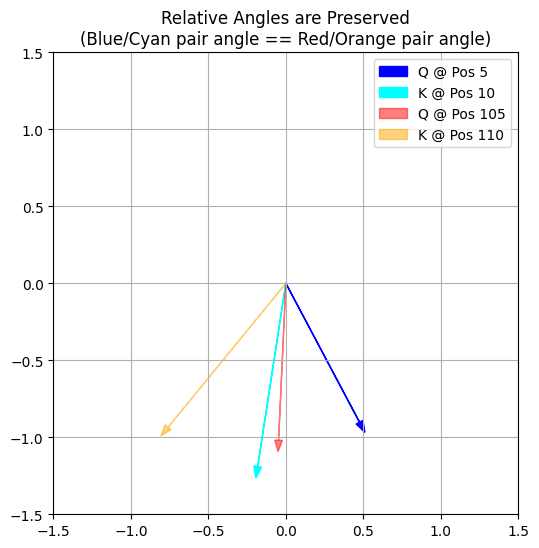

In [2]:
def get_dot_product_angle(v1, v2):
    """Calculates cosine similarity (dot product) between two vectors."""
    # Using numpy dot product
    dot_prod = np.dot(v1, v2)
    # We assume normalized vectors for simplicity in this visualization
    return dot_prod

# Let's define two arbitrary semantic vectors (Query and Key)
# Q wants to find K. They point in slightly different directions.
Q_base = np.array([1.0, 0.2]) 
K_base = np.array([0.8, 0.9])

# --- SCENARIO A: Start of the sentence ---
pos_Q_A = 5
pos_K_A = 10  # Distance is 5

# Apply RoPE to both based on their positions
Q_rotated_A = get_rotated_2d_vector(Q_base, pos_Q_A, d_model, head_dim_pair)
K_rotated_A = get_rotated_2d_vector(K_base, pos_K_A, d_model, head_dim_pair)

# Calculate Attention Score (Dot Product)
score_A = get_dot_product_angle(Q_rotated_A, K_rotated_A)


# --- SCENARIO B: Deep in the sentence ---
# We shift both positions by +100. The relative distance is STILL 5.
pos_Q_B = 105
pos_K_B = 110 

# Apply RoPE to both based on new positions
Q_rotated_B = get_rotated_2d_vector(Q_base, pos_Q_B, d_model, head_dim_pair)
K_rotated_B = get_rotated_2d_vector(K_base, pos_K_B, d_model, head_dim_pair)

# Calculate Attention Score (Dot Product)
score_B = get_dot_product_angle(Q_rotated_B, K_rotated_B)

# --- RESULTS ---
print("--- The Magic of Relative Attention ---")
print(f"Scenario A: Q at pos {pos_Q_A}, K at pos {pos_K_A} (Dist 5). Score: {score_A:.6f}")
print(f"Scenario B: Q at pos {pos_Q_B}, K at pos {pos_K_B} (Dist 5). Score: {score_B:.6f}")

np.testing.assert_almost_equal(score_A, score_B)
print("\nSUCCESS: The attention scores are identical despite absolute positions changing!")

# --- Visualizing the Scenario B vectors to show they really did rotate ---
plt.figure(figsize=(6,6))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
# Draw Scenario A pair
plt.arrow(0, 0, Q_rotated_A[0], Q_rotated_A[1], head_width=0.05, color='blue', label=f'Q @ Pos {pos_Q_A}')
plt.arrow(0, 0, K_rotated_A[0], K_rotated_A[1], head_width=0.05, color='cyan', label=f'K @ Pos {pos_K_A}')

# Draw Scenario B pair (translucent)
plt.arrow(0, 0, Q_rotated_B[0], Q_rotated_B[1], head_width=0.05, color='red', alpha=0.5, label=f'Q @ Pos {pos_Q_B}')
plt.arrow(0, 0, K_rotated_B[0], K_rotated_B[1], head_width=0.05, color='orange', alpha=0.5, label=f'K @ Pos {pos_K_B}')

plt.title("Relative Angles are Preserved\n(Blue/Cyan pair angle == Red/Orange pair angle)")
plt.legend()
plt.show()